<a href="https://colab.research.google.com/github/dgazeyreyn/mind_diagnostics/blob/main/Mind_Diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================
# Imports and Authentication
# ==========================

In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import re
from google.colab import auth
from google.cloud import bigquery
from scipy.stats import chi2_contingency

# Set matplotlib settings
plt.rc("font", size=14)

# Authenticate Google Cloud access
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# =======================
# Load Data from BigQuery
# =======================

In [ ]:
# Initialize BigQuery client and project ID
project_id = 'sandbox-418514'
client = bigquery.Client(project=project_id)

# Query data from BigQuery
query = """
SELECT *
FROM `sandbox-418514.sample_data.visitor_signups_data`
"""
df = client.query(query).to_dataframe()

# Display a preview of the dataset
df.head()

,mduid,bh_goal_name,region,browser,os_name
0,c3dd9c9787287cb2c3649933e05aadb6,None,Rhode Island,desktop_web,Linux
1,26a3aaee9cb2b0230f871a120b197dc0,None,South Dakota,desktop_web,Linux
2,ef7040df7893df97e3de1dab358a04bd,None,Rhode Island,desktop_web,Linux
3,1e5615df1c93f69a17095fb353563a7c,None,Rhode Island,desktop_web,Linux
4,e8ac65b98db15608c190bf30cb487693,None,Montana,desktop_web,Ubuntu


In [ ]:
# ===============================
# Data Cleaning and Preprocessing
# ===============================

In [ ]:
# Create a summary of non-null values and missing values for each column
fields_values_cnt_df = df.count().to_frame(name='values_count')
fields_nulls_cnt_df = df.isnull().sum().to_frame(name='nulls_count')
fields_summary_df = fields_values_cnt_df.join(fields_nulls_cnt_df, how='left')

# Clean up 'browser' column and recategorize 'os_name'
df['browser_rev'] = df['browser'].apply(lambda x: 'mobile_web' if (x == 'mobile_web') or (x == 'mobile_web}') else 'desktop_web')
df['os_name_rev'] = df['os_name'].apply(lambda x: 'unassigned' if x == None else x)

# Grouping operating systems
os_list = ['iOS', 'Android', 'Windows', 'macOS', 'Chrome OS']
df['os_name_grouped'] = np.where(df['os_name_rev'].isin(os_list), df['os_name_rev'], 'Other')

# Creating binary 0/1 values to a new user_signups dependent variable
df['user_signups'] = df['bh_goal_name'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Replacing values containing spaces with an '_' to prevent downstream logistic regression from throwing errors
df = df.replace(' ', '_', regex=True)

In [ ]:
# =============================================================
# Performing Chi-square Tests of Independence (Omnibus Testing)
# =============================================================

In [ ]:
# Function to perform Chi-square test and print the result
def chi_square_test(df, col1, col2):
    """
    Perform Chi-square test of independence between two categorical variables.

    Parameters:
    df (DataFrame): The input DataFrame
    col1 (str): First categorical column
    col2 (str): Second categorical column

    Returns:
    None (prints the result)
    """
    # Create a contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])

    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square Test of Independence between {col1} and {col2}:")
    print(f"Chi2 Statistic = {chi2:.2f}, p-value = {p:.4f}, Degrees of Freedom = {dof}")
    print(f"Expected Frequencies:\n{expected}\n")
    if p < 0.05:
        print("Result: Significant relationship (reject the null hypothesis)\n")
    else:
        print("Result: No significant relationship (fail to reject the null hypothesis)\n")

# Example: Test the independence between 'os_name_grouped' and 'target_variable'
# chi_square_test(df, 'browser_rev', 'user_signups')

In [ ]:
# List of column pairs to test
column_pairs = [
    ('browser_rev', 'user_signups'),
    ('os_name_grouped', 'user_signups'),
    ('region', 'user_signups')
]

# Run Chi-square tests for each pair
for col1, col2 in column_pairs:
    chi_square_test(df, col1, col2)

Chi-square Test of Independence between browser_rev and user_signups:
Chi2 Statistic = 295.63, p-value = 0.0000, Degrees of Freedom = 1
Expected Frequencies:
[[ 80927.99583108   1341.00416892]
 [445736.00416892   7385.99583108]]

Result: Significant relationship (reject the null hypothesis)

Chi-square Test of Independence between os_name_grouped and user_signups:
Chi2 Statistic = 256.33, p-value = 0.0000, Degrees of Freedom = 5
Expected Frequencies:
[[1.44885203e+05 2.40079666e+03]
 [6.55242412e+03 1.08575876e+02]
 [6.92426263e+03 1.14737366e+02]
 [3.06835630e+04 5.08436982e+02]
 [3.23686407e+05 5.36359287e+03]
 [1.39321397e+04 2.30860252e+02]]

Result: Significant relationship (reject the null hypothesis)

Chi-square Test of Independence between region and user_signups:
Chi2 Statistic = 232.37, p-value = 0.0000, Degrees of Freedom = 50
Expected Frequencies:
[[9.73174176e+03 1.61258241e+02]
 [8.18438203e+02 1.35617969e+01]
 [1.21427899e+04 2.01210121e+02]
 [5.12999427e+03 8.50057341e+

In [ ]:
# ==============================================================
# Performing Chi-square Tests of Independence (Post Hoc Testing)
# ==============================================================

In [ ]:
# Browser and User Signups
browser_dummies = pd.get_dummies(df['browser_rev'])
for series in browser_dummies:
    nl = "\n"

    browser_crosstab = pd.crosstab(browser_dummies[f"{series}"], df['user_signups'])
    print(browser_crosstab, nl)
    chi2, p, dof, expected = stats.chi2_contingency(browser_crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

user_signups      no   yes
desktop_web               
False         445161  7961
True           81503   766 

Chi2 value= 295.63074097725536
p-value= 2.949230378104203e-66
Degrees of freedom= 1

user_signups      no   yes
mobile_web                
False          81503   766
True          445161  7961 

Chi2 value= 295.63074097725536
p-value= 2.949230378104203e-66
Degrees of freedom= 1



In [ ]:
# Operating System and User Signups
os_dummies = pd.get_dummies(df['os_name_grouped'])
for series in os_dummies:
    nl = "\n"

    os_crosstab = pd.crosstab(os_dummies[f"{series}"], df['user_signups'])
    print(os_crosstab, nl)
    chi2, p, dof, expected = stats.chi2_contingency(os_crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

user_signups      no   yes
Android                   
False         382255  5850
True          144409  2877 

Chi2 value= 132.1832100650528
p-value= 1.3642907584803792e-30
Degrees of freedom= 1

user_signups      no   yes
Chrome_OS                 
False         520142  8588
True            6522   139 

Chi2 value= 8.489538562617811
p-value= 0.003571943892870518
Degrees of freedom= 1

user_signups      no   yes
Other                     
False         519659  8693
True            7005    34 

Chi2 value= 57.80076591753746
p-value= 2.900567590830519e-14
Degrees of freedom= 1

user_signups      no   yes
Windows                   
False         495817  8382
True           30847   345 

Chi2 value= 56.36489743199644
p-value= 6.019546830580369e-14
Degrees of freedom= 1

user_signups      no   yes
iOS                       
False         202804  3537
True          323860  5190 

Chi2 value= 14.73416466407495
p-value= 0.00012378280360961967
Degrees of freedom= 1

user_signups      no   yes
ma

In [ ]:
# State and User Signups

state_dummies = pd.get_dummies(df['region'])
for series in state_dummies:
    nl = "\n"

    state_crosstab = pd.crosstab(state_dummies[f"{series}"], df['user_signups'])
    print(state_crosstab, nl)
    chi2, p, dof, expected = stats.chi2_contingency(state_crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

user_signups      no   yes
Alabama                   
False         517017  8481
True            9647   246 

Chi2 value= 45.57958477735258
p-value= 1.46561199485913e-11
Degrees of freedom= 1

user_signups      no   yes
Alaska                    
False         525843  8716
True             821    11 

Chi2 value= 0.31914451080741424
p-value= 0.5721222167121032
Degrees of freedom= 1

user_signups      no   yes
Arizona                   
False         514501  8546
True           12163   181 

Chi2 value= 2.009076857156462
p-value= 0.15636043660766263
Degrees of freedom= 1

user_signups      no   yes
Arkansas                  
False         521561  8615
True            5103   112 

Chi2 value= 8.477035331515742
p-value= 0.0035965775444460183
Degrees of freedom= 1

user_signups      no   yes
California                
False         477970  8060
True           48694   667 

Chi2 value= 26.15875150725036
p-value= 3.144686411059312e-07
Degrees of freedom= 1

user_signups      no   yes
Colorad

In [ ]:
# =========================
# Logistic Regression Model
# =========================

In [ ]:
# Prepare data for logistic regression
# Replace 'target_variable' with your actual target column name
X = df[['browser_rev', 'os_name_grouped', 'region']]  # Replace with your relevant features

# Convert categorical variables to dummy variables
# Holding off on drop_first=True in favor of specifying in next step
X = pd.get_dummies(X)

# Dropping 'browser_rev_desktop_web', 'os_name_grouped_iOS', 'region_California'
X = X.drop(['browser_rev_desktop_web', 'os_name_grouped_iOS', 'region_California'], axis=1)

# Convert boolean columns to integers (True/False -> 1/0)
X = X.astype(int)

# Extract the target variable
y = df['user_signups']

# Align the indices of X and y to ensure they match
X, y = X.align(y, join='inner', axis=0)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# # Build and fit the logistic regression model
try:
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    print(result.summary())
except ValueError as e:
    print(f"Error fitting model: {e}")

Optimization terminated successfully.
         Current function value: 0.082529
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           user_signups   No. Observations:               535391
Model:                          Logit   Df Residuals:                   535334
Method:                           MLE   Df Model:                           56
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                0.008867
Time:                        16:01:30   Log-Likelihood:                -44186.
converged:                       True   LL-Null:                       -44581.
Covariance Type:            nonrobust   LLR p-value:                2.703e-130
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -5.5883      0.103    -54.030      0.000   

In [ ]:
# ===========================================================
# Extract Coefficients, Odds Ratios, and Confidence Intervals
# ===========================================================

In [ ]:
# Extracting coefficients, odds ratios, and confidence intervals
coefs = result.params.to_frame(name='coef')
coefs['odds_ratio'] = np.exp(coefs['coef'])

# Calculate 95% confidence intervals
conf = result.conf_int()
conf.columns = ['ci_lower', 'ci_upper']
coefs = coefs.join(conf)

# Calculate odds ratio confidence intervals
coefs['ci_lower_odds'] = np.exp(coefs['ci_lower'])
coefs['ci_upper_odds'] = np.exp(coefs['ci_upper'])

# Determine significance based on p-values
coefs['p_value'] = result.pvalues
coefs['significant'] = np.where(coefs['p_value'] < 0.05, 'significant', 'not_significant')

# Reset index for easier plotting
coefs.reset_index(inplace=True)
coefs.rename(columns={'index': 'feature'}, inplace=True)

# Display the coefficient DataFrame
coefs.head()

,feature,coef,odds_ratio,ci_lower,ci_upper,ci_lower_odds,ci_upper_odds,p_value,significant
0,const,-5.588335,0.003741,-5.791056,-5.385615,0.003055,0.004582,0.000000e+00,significant
1,browser_rev_mobile_web,1.320547,3.745471,1.130352,1.510743,3.096746,4.530094,3.577345e-42,significant
2,os_name_grouped_Android,0.193028,1.212916,0.146795,0.239261,1.158117,1.270309,2.766177e-16,significant
3,os_name_grouped_Chrome_OS,1.564261,4.779140,1.311335,1.817186,3.711126,6.154516,8.103005e-34,significant
4,os_name_grouped_Other,0.057107,1.058769,-0.326179,0.440394,0.721676,1.553318,7.702694e-01,not_significant


In [ ]:
# =====================================
# Creating Visualizations (Forest Plot)
# =====================================

In [40]:
# Define the prefixes to remove
prefixes = ['browser_rev_', 'os_name_grouped_', 'region_']

# Create a regex pattern to match any of the prefixes
pattern = '^(' + '|'.join(prefixes) + ')'

# Remove the prefixes using str.replace()
coefs['feature'] = coefs['feature'].str.replace(pattern, '', regex=True)

# Display the updated DataFrame
coefs.head()

,feature,coef,odds_ratio,ci_lower,ci_upper,ci_lower_odds,ci_upper_odds,p_value,significant,state_sub_region,category
0,const,-5.588335,0.003741,-5.791056,-5.385615,0.003055,0.004582,0.000000e+00,significant,NaN,NaN
1,mobile_web,1.320547,3.745471,1.130352,1.510743,3.096746,4.530094,3.577345e-42,significant,NaN,Browser
2,Android,0.193028,1.212916,0.146795,0.239261,1.158117,1.270309,2.766177e-16,significant,NaN,Operating System
3,Chrome_OS,1.564261,4.779140,1.311335,1.817186,3.711126,6.154516,8.103005e-34,significant,NaN,Operating System
4,Other,0.057107,1.058769,-0.326179,0.440394,0.721676,1.553318,7.702694e-01,not_significant,NaN,Operating System


In [41]:
# creating a dictionary mapping features to categories
feature_mapping = {
    'mobile_web': 'Browser',
    'Android': 'Operating System',
    'Chrome_OS': 'Operating System',
    'macOS': 'Operating System',
    'Other': 'Operating System',
    'Windows': 'Operating System',
    'Alabama': 'East South Central',
    'Alaska': 'Pacific',
    'Arizona': 'Mountain',
    'Arkansas': 'West South Central',
    'Colorado': 'Mountain',
    'Connecticut': 'New England',
    'Delaware': 'South Atlantic',
    'District_of_Columbia': 'South Atlantic',
    'Florida': 'South Atlantic',
    'Georgia': 'South Atlantic',
    'Hawaii': 'Pacific',
    'Idaho': 'Mountain',
    'Illinois': 'East North Central',
    'Indiana': 'East North Central',
    'Iowa': 'West North Central',
    'Kansas': 'West North Central',
    'Kentucky': 'East South Central',
    'Louisiana': 'West South Central',
    'Maine': 'New England',
    'Maryland': 'South Atlantic',
    'Massachusetts': 'New England',
    'Michigan': 'East North Central',
    'Minnesota': 'West North Central',
    'Mississippi': 'East South Central',
    'Missouri': 'West North Central',
    'Montana': 'Mountain',
    'Nebraska': 'West North Central',
    'Nevada': 'Mountain',
    'New_Hampshire': 'New England',
    'New_Jersey': 'Middle Atlantic',
    'New_Mexico': 'Mountain',
    'New_York': 'Middle Atlantic',
    'North_Carolina': 'South Atlantic',
    'North_Dakota': 'West North Central',
    'Ohio': 'East North Central',
    'Oklahoma': 'West South Central',
    'Oregon': 'Pacific',
    'Pennsylvania': 'Middle Atlantic',
    'Rhode_Island': 'New England',
    'South_Carolina': 'South Atlantic',
    'South_Dakota': 'West North Central',
    'Tennessee': 'East South Central',
    'Texas': 'West South Central',
    'Utah': 'Mountain',
    'Vermont': 'New England',
    'Virginia': 'South Atlantic',
    'Washington': 'Pacific',
    'West_Virginia': 'South Atlantic',
    'Wisconsin': 'East North Central',
    'Wyoming': 'Mountain'
}
coefs['category'] = coefs['feature'].map(feature_mapping)

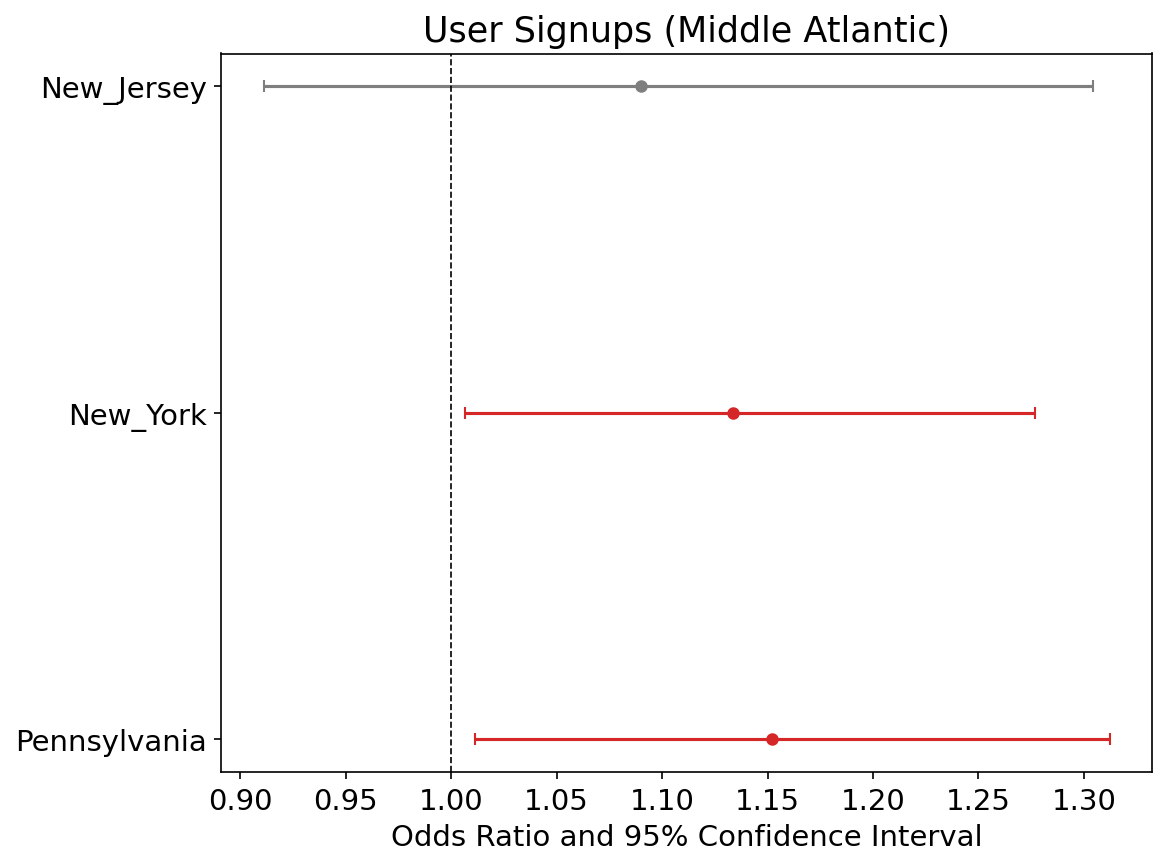

In [61]:
# Create a forest plot for the odds ratios
def plot_forest(data, category, title):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

    # Filter data for the specified region
    cat_data = coefs.loc[coefs['category'] == category]

    # Sort the data for better visual organization
    cat_data = cat_data.iloc[::-1]

    for idx, row in cat_data.iterrows():
        ci = [[row['odds_ratio'] - row['ci_lower_odds']], [row['ci_upper_odds'] - row['odds_ratio']]]
        color = 'tab:red' if row['significant'] == 'significant' else 'tab:gray'

        # Plot the odds ratio with error bars
        plt.errorbar(x=[row['odds_ratio']], y=[row['feature']],
                     xerr=ci, ecolor=color, capsize=3, linestyle='None',
                     marker="o", markersize=5, mfc=color, mec=color)

    # Add reference line at odds ratio = 1
    plt.axvline(x=1, linestyle='--', color='black', linewidth=0.8)
    plt.xlabel('Odds Ratio and 95% Confidence Interval')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generate a forest plot for a specific region (e.g., 'Middle_Atlantic')
plot_forest(coefs, category='Middle Atlantic', title='User Signups (Middle Atlantic)')